In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import time
from dateutil.relativedelta import relativedelta

%matplotlib inline
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# matplotlib.style.use('seaborn-paper')
import matplotlib.pyplot as plt

In [3]:
os.chdir("../../raw_data/")
factor_name = "profit"
df_future_price = pd.read_csv("CF_price.csv")
df_factor = pd.read_csv(f"CF_{factor_name}.csv")

In [20]:
df_factor

,Unnamed: 0,Symbol,SymbolDate,UpdateDate,DelayDate,SymbolVal,Tag,ValStr
0,0,进口棉利润,2013-01-04,2021-07-14,NaN,5808.0,NaN,NaN
1,1,进口棉利润,2013-01-07,2021-07-14,NaN,5878.0,NaN,NaN
2,2,进口棉利润,2013-01-08,2021-07-14,NaN,5804.0,NaN,NaN
3,3,进口棉利润,2013-01-09,2021-07-14,NaN,5864.0,NaN,NaN
4,4,进口棉利润,2013-01-10,2021-07-14,NaN,5906.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2396,2396,进口棉利润,2023-03-22,2023-03-23,NaN,-251.0,NaN,NaN
2397,2397,进口棉利润,2023-03-24,2023-03-27,NaN,-219.0,NaN,NaN
2398,2398,进口棉利润,2023-03-28,2023-03-29,NaN,-540.0,NaN,NaN
2399,2399,进口棉利润,2023-03-30,2023-03-31,NaN,-869.0,NaN,NaN


In [5]:
df_factor_2 = pd.read_csv(f"CF_consume_1.csv")
df_factor_2

,Unnamed: 0,Symbol,SymbolDate,UpdateDate,DelayDate,SymbolVal,Tag,ValStr
0,0,棉花:抛储:成交量|DZ,2010-08-10,2021-10-26,NaN,15029.000,NaN,NaN
1,1,棉花:抛储:成交量|DZ,2010-08-11,2021-10-26,NaN,14483.000,NaN,NaN
2,2,棉花:抛储:成交量|DZ,2010-08-12,2021-10-26,NaN,15106.000,NaN,NaN
3,3,棉花:抛储:成交量|DZ,2010-08-13,2021-10-26,NaN,15005.000,NaN,NaN
4,4,棉花:抛储:成交量|DZ,2010-08-16,2021-10-26,NaN,14989.000,NaN,NaN
...,...,...,...,...,...,...,...,...
1079,1079,棉花:抛储:成交量|DZ,2021-11-24,2021-11-25,NaN,15413.782,NaN,NaN
1080,1080,棉花:抛储:成交量|DZ,2021-11-25,2021-11-26,NaN,7208.597,NaN,NaN
1081,1081,棉花:抛储:成交量|DZ,2021-11-26,2021-11-29,NaN,5815.770,NaN,NaN
1082,1082,棉花:抛储:成交量|DZ,2021-11-29,2021-11-30,NaN,6418.342,NaN,NaN


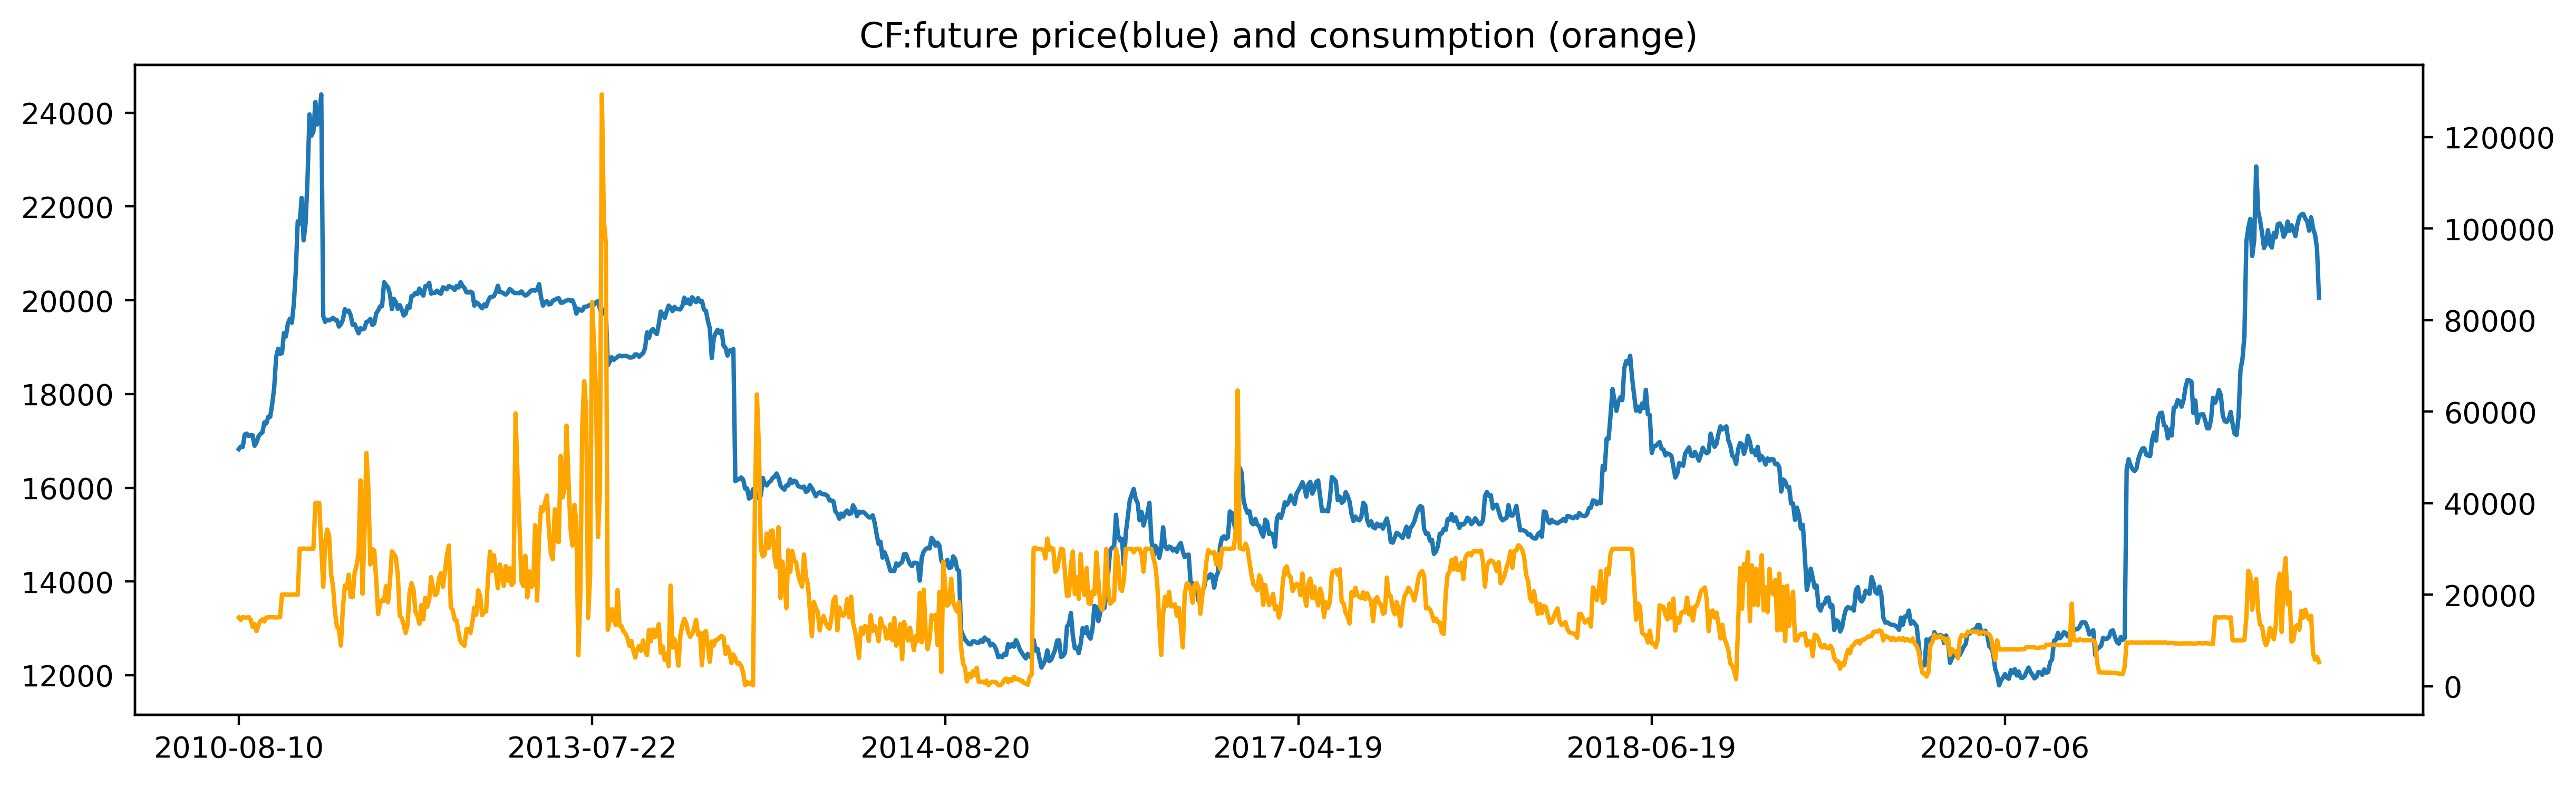

In [33]:
# merge spot price and future price to compute the basis

df_factor_part = df_factor_2[['SymbolDate', 'SymbolVal']]
df_future_part = df_future_price[['CLOCK', 'CLOSE']]

df_merge = df_future_part.merge(df_factor_part, left_on="CLOCK", right_on="SymbolDate")
df_merge = df_merge[['CLOCK', 'CLOSE', 'SymbolVal']]
df_merge.columns = ['date', 'futurePrice', 'factor']

# visualize spot and future price
fig, ax1 = plt.subplots(dpi=400)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(df_merge['date'], df_merge['futurePrice'])

ax2 = ax1.twinx()
ax2.plot(df_merge['date'], df_merge['factor'], color="orange")

plt.xlabel("date")

plt.xticks(rotation=45)

ax1.set_xticks([x for x in range(0,len(df_merge['date']),180)])

plt.title('CF:future price(blue) and consumption (orange)')

plt.show()

In [34]:
# profit
df_merge['factor_shift'] = df_merge['factor'].shift(1)
df_input = df_merge[['date', 'factor_shift']].dropna()
df_input.columns = ['date', 'factor_indicator']

gap_day = 7 # the report uses 2, should try other values as well
df_output = df_merge[['date', 'futurePrice']]
df_output['gap_days_later_close'] = df_merge['futurePrice'].shift(-gap_day)
df_output = df_output.dropna()
df_output['y'] = np.where((df_output['gap_days_later_close'] - df_output['futurePrice']) >= 0, 1, 0)
# df_output.columns = ['date', 'CLOSE', 'two_days_later_close', 'y']
df_output = df_output[['date', 'y']]

# merge input and output
df_dataset = df_input.merge(df_output, on='date')
df_dataset = df_dataset[['date', 'factor_indicator', 'y']]
df_dataset

,date,factor_indicator,y
0,2010-08-11,15029.000,1
1,2010-08-12,14483.000,1
2,2010-08-13,15106.000,0
3,2010-08-16,15005.000,0
4,2010-08-17,14989.000,1
...,...,...,...
1048,2021-11-15,12973.644,1
1049,2021-11-16,13361.981,0
1050,2021-11-17,12342.700,0
1051,2021-11-18,16428.480,0


,date,factor_indicator,y
0,2013-01-07,5808.0,1
1,2013-01-08,5878.0,1
2,2013-01-09,5804.0,1
3,2013-01-10,5864.0,1
4,2013-01-11,5906.0,1
...,...,...,...
2358,2023-03-16,-557.0,1
2359,2023-03-20,-234.0,0
2360,2023-03-22,-397.0,1
2361,2023-03-24,-251.0,1
